In [1]:
%pip install spacy
!python -m spacy download es_core_news_md

Note: you may need to restart the kernel to use updated packages.
     ---------------------------------------- 0.0/42.3 MB ? eta -:--:--
     ---------------------------------------- 0.0/42.3 MB ? eta -:--:--
     ---------------------------------------- 0.5/42.3 MB 2.8 MB/s eta 0:00:15
     - -------------------------------------- 2.1/42.3 MB 5.9 MB/s eta 0:00:07
     ---- ----------------------------------- 4.5/42.3 MB 7.9 MB/s eta 0:00:05
     ------ --------------------------------- 6.8/42.3 MB 8.9 MB/s eta 0:00:04
     -------- ------------------------------- 8.9/42.3 MB 9.4 MB/s eta 0:00:04
     ---------- ---------------------------- 11.5/42.3 MB 10.0 MB/s eta 0:00:04
     ------------- ------------------------- 14.4/42.3 MB 10.7 MB/s eta 0:00:03
     --------------- ----------------------- 16.8/42.3 MB 10.9 MB/s eta 0:00:03
     ------------------ -------------------- 20.2/42.3 MB 11.3 MB/s eta 0:00:02
     --------------------- ----------------- 23.6/42.3 MB 11.9 MB/s eta 0:0

## 1. Carga de los datos

In [2]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
import tensorflow as tf
import numpy as np
from keras import layers
import pandas as pd
from tqdm import tqdm
import spacy
from sklearn.preprocessing import LabelEncoder
from keras._tf_keras.keras.preprocessing.text import one_hot
nlp = spacy.load("es_core_news_md")

splits = {'train': 'train.csv', 'validation': 'validation.csv'}
trainning_df = pd.read_csv("hf://datasets/Ernesto-1997/Sarcastic_spanish_dataset/" + splits["train"])
validation_df = pd.read_csv("hf://datasets/Ernesto-1997/Sarcastic_spanish_dataset/" + splits["validation"])

print('Número de Comentarios de entrenamiento Cargados: {num}'.format(num=trainning_df.shape[0]))
print('Número de Comentarios de validación Cargados: {num}'.format(num=validation_df.shape[0]))

trainning_comentarios = [list(x) for x in trainning_df[['Texto', 'Sarcasmo']].values]
validation_comentarios = [list(x) for x in validation_df[['Texto', 'Sarcasmo']].values]

c:\Users\LAGD\Documents\UCAB\10mo Semestre\IA\Proyectos\Proyecto2_IA\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Número de Comentarios de entrenamiento Cargados: 15276
Número de Comentarios de validación Cargados: 3820


## 2. Normalización y tokenización de los datos

Para procesar los comentarios o textos de una forma acorde y generalizada, debemos pasar las mismas por un proceso de normalización y tokenización. 

> Normalización: En este proceso nos encargamos de "limpiar" el texto. Quitamos los signos de puntuación y convertimos la palabra a su raíz o lema.

> Tokenización: Cada frase la tratamos como un conjunto de tokens o palabras (en este caso). Posteriormente tomaremos un conjunto de palabras que formarán una secuencia de tokens


In [6]:
import random

nlp = spacy.load('es_core_news_md')

def normalize(comentarios, min_word=5):

    comentarios_list = []
    for comentario in tqdm(comentarios):

        # Tokenizamos el comentario
        comment = nlp(comentario[0].replace('.', ' ').replace('-', '').replace('?', ' ').replace('!', ' ').replace(',', ' ').replace('¿', ' ').replace('¡', ' ').strip())

        comment = ([word.lemma_ for word in comment if (not word.is_punct) and (not ':' in word.text)])

        if (len(comment) > min_word):
            comentarios_list.append([' '.join(comment), comentario[1]])
    return comentarios_list

X_train_norm = normalize(trainning_comentarios)
X_test_norm = normalize(validation_comentarios)


100%|██████████| 3820/3820 [00:11<00:00, 344.12it/s]


In [ ]:
sarcastic = []
not_sarcastic = []

for comment in X_train_norm:
    if (comment[1] == 1):
        sarcastic.append(comment)
    else:
        not_sarcastic.append(comment)

print('Comentarios Sarcasticos: {}'.format(len(sarcastic)))
print('Comentarios No Sarcasticos: {}'.format(len(not_sarcastic)))

not_sarcastic = not_sarcastic[:-1917]

print('Comentarios No Sarcasticos: {}'.format(len(not_sarcastic)))

X_train_norm = sarcastic + not_sarcastic

X_train_norm = random.sample(X_train_norm, len(X_train_norm))

X_train = [doc[0] for doc in X_train_norm]
y_train = np.array([doc[1] for doc in X_train_norm])
X_test = [doc[0] for doc in X_test_norm]
y_test = np.array([doc[1] for doc in X_test_norm])

print('comentarios de entrenamiento: {}'.format(len(X_train)))
print('comentarios de Test: {}'.format(len(X_test)))

Comentarios Sarcasticos: 5947
Comentarios No Sarcasticos: 7864
Comentarios No Sarcasticos: 5947
[['oh   claro   ser famoso ser tener amigo verdadero que siempre estar ahí     por tu dinero', 1], ['el parking de Pueblosol abrir este viernes al público a uno euro al día en el centro de Arroyo de el Miel', 0], ['Trànsit él defender de el crítica por el corte de el AP7 querer evitar uno choque múltiple', 0], ['Belfast   el origen del Titanic', 0], ['ser él que haber   sordidez vendible en el plataforma', 0], ['qué ocultar el comentario que hacer el visita sobre tu casa', 1], ['yo ser policía y tú erar ladrón', 0], ['este vibrador susurrar al oído expresión como igualdad salarial o Conciliación familiar provocar el orgasmo en menos de dos minuto', 1], ['sumar proposes European strategy against organised crime on the Costa del Sol', 0], ['al Real Madrid él saltar el plomo en Estambul', 0], ['ven a mi hija   no haber nada que no hacer para volver a ver él', 0], ['Ecuador elegir a Jhonatan Nar

## 3. One hot encoding

El one hot encoding es un proceso que consiste en definir un diccionario de palabras de ${n}$ cantidad de palabras, y convertir cada uno de los tokens (o palabras en este caso) a un arreglo que contiene tantas posiciones como el diccionario tenga. 

Con esto se busca que el modelo no interprete los tokens con proporciones numéricas, sino que al cada uno ser un vector con dimensión ${n}$ y nada más contener una unidad en la posición correspondiente a la ubicación del token, todos estos tokens serán equidistantes entre ellos.

#### **Ejemplo**

Supongamos que tenemos un diccionario con tres palabras: **Casa**, **Cerca** y **Astronauta**

Al realizar la tokenización es posible que estas palabras queden de la siguiente forma:

- Casa = 10
- Cerca = 21
- Astronauta = 30

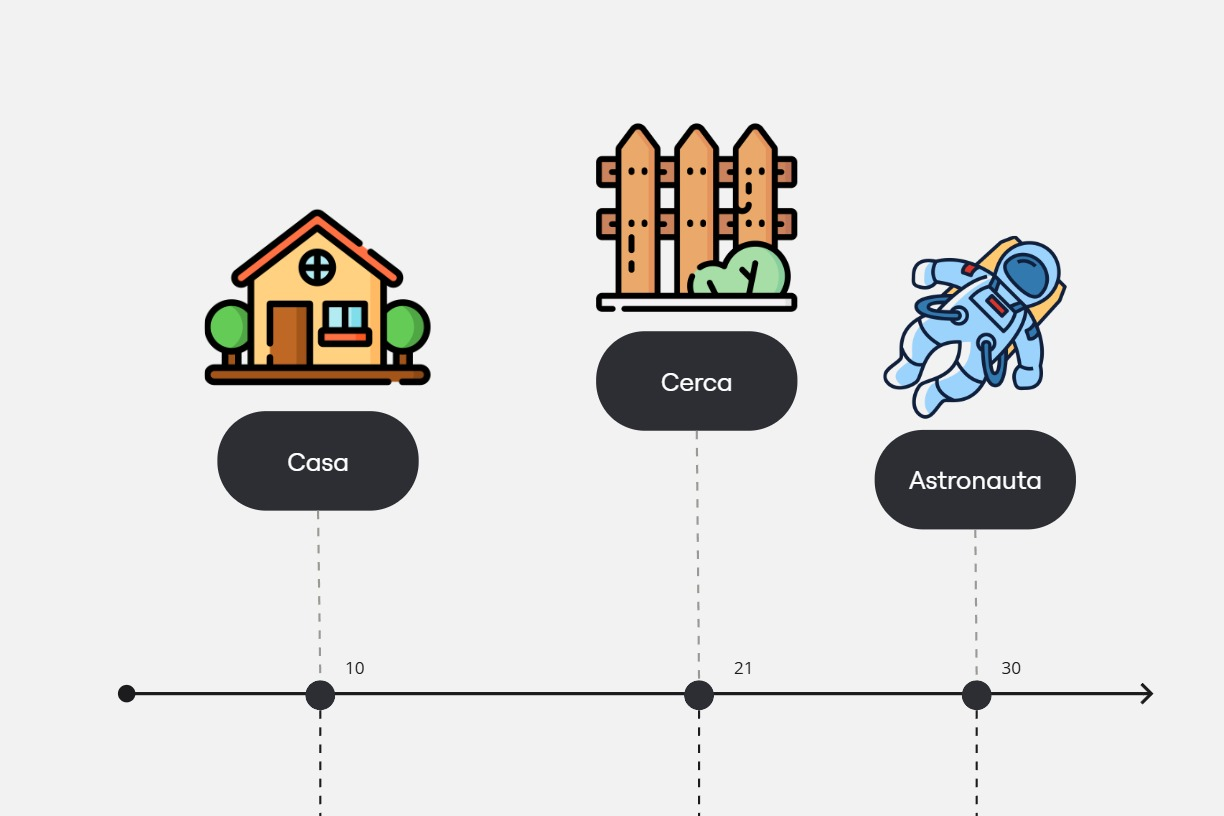

Si nos guiamos por esto, la red interpretaría que Astronauta "vale" o "es" el triple que casa, y que cerca es un poquito más del doble de casa y que es algo entre casa y astronauta; podemos ver que nada esto tiene ningún tipo de sentido. Lo que se busca es que en principio la red evalúe cada token como elementos equidistantes entre cada uno de ellos, y por eso hacemos el one hot encoding. Al hacer el One Hot encoding, nuestras palabras lucirían de la siguiente forma:

- Casa = [1, 0, 0]
- Cerca = [0, 1, 0]
- Astronauta = [0, 0, 1]

Lo que graficamente se vería de la siguiente forma

![Untitled (1).jpg](<attachment:Untitled (1).jpg>)

Evidentemente, al crear diccionarios con miles de palabras, es ineficiente trabajar con vectores tan grandes solo para representar la posición en el "espacio" de una palabra (o token). Esto lo solucionaremos comprimiendo los datos en una capa de embedding en el modelo.

Al mismo tiempo, la naturaleza del lenguaje hace que sí existan palabras relacionadas, pudiendo decir que hay palabras que sí se acercan más a unas que a otras, la capa de embedding también nos ayudará con esto.

In [8]:
VOCAB_SIZE = 100000
X_train = [one_hot(doc, VOCAB_SIZE) for doc in X_train]
X_test = [one_hot(doc, VOCAB_SIZE) for doc in X_test]

encoder = LabelEncoder()
encoder.fit(y_train)

y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

class_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print("Mapeo de clases:", class_mapping)
print("1: Sarcasmo")
print("0: Normal")

Mapeo de clases: {np.int64(0): np.int64(0), np.int64(1): np.int64(1)}
1: Sarcasmo
0: Normal


## 4. Creación de secuencias de palabras

In [9]:
MAX_WORDS = 50
pad_corpus_train = keras.utils.pad_sequences(X_train, maxlen=MAX_WORDS, padding='post')
pad_corpus_test = keras.utils.pad_sequences(X_test, maxlen=MAX_WORDS, padding='post')

print(pad_corpus_test[0])

[46758 97777 72365 35457 95078 48757 15756 53929 74343 87390 68422 97777
  3561  3530     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]


## 5. Creación del modelo

El modelo consta de 4 capas.

**1. Capa de Embedding:**

> La capa de Embedding, recibirá tantas entradas como palabras haya en el diccionario. El embedding size define la cantidad de dimensiones (o características) por las cuales se va a clasificar cada una de las palabras que entren en la red; [este conjunto de características van a otorgar la cercanía entre las palabras (clustering) para posteriormente clasificar cada uno de los textos](https://projector.tensorflow.org/).

**2. Capa LSTM:**

> La capa LSTM nos servirá se utiliza para capturar y recordar las secuencias de datos.

**3. Dropout:**

> Con esta capa conseguimos descartar aleatoreamente un porcentaje de neuronas en cada capa en cada paso del entrenamiento, obligando a no depender demasiado de ninguna neurona en particular y aprender de una forma más generalizable; esto se hace con el fin de aprender el overfitting

**4. Capa de salida**

> Se define una capa con densidad 2 ya que al ser un clasificador binario podemos tener dos posibles salidas.

In [10]:
from keras.api.layers import Dense, Dropout, LSTM, Embedding
from keras import Sequential

EMBEDDING_SIZE = 32

model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBEDDING_SIZE))
model.add(LSTM(12, input_shape=(MAX_WORDS, EMBEDDING_SIZE)))
model.add(Dropout(0.05))
model.add(Dense(2, activation='softmax'))
# Compilación del modelo
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

c:\Users\LAGD\Documents\UCAB\10mo Semestre\IA\Proyectos\Proyecto2_IA\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## 6. Entrenamiento

In [16]:
# Entrenamiento del modelo
history = model.fit(pad_corpus_train, y_train, epochs=32, batch_size=32, validation_data=(pad_corpus_test, y_test))


Epoch 1/32
372/372 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8296 - loss: 0.4059 - val_accuracy: 0.7099 - val_loss: 0.6023
Epoch 2/32
372/372 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8312 - loss: 0.4044 - val_accuracy: 0.7131 - val_loss: 0.5872
Epoch 3/32
372/372 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8440 - loss: 0.3838 - val_accuracy: 0.7216 - val_loss: 0.6056
Epoch 4/32
372/372 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8567 - loss: 0.3682 - val_accuracy: 0.7260 - val_loss: 0.5886
Epoch 5/32
372/372 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8691 - loss: 0.3440 - val_accuracy: 0.7301 - val_loss: 0.6082
Epoch 6/32
372/372 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8803 - loss: 0.3290 - val_accuracy: 0.7344 - val_loss: 0.5891
Epoch 7/32
372/372 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8820 - loss: 0.3234 - val_accuracy: 0.7453 - val_loss: 0.6131
Epoch 8/32
372/372 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8605 - loss: 0.3501 - val_accu

## 7. Evaluación del modelo

In [12]:
# Evaluación del modelo
loss, accuracy = model.evaluate(pad_corpus_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7070 - loss: 0.5784
Loss: 0.5810904502868652, Accuracy: 0.7058135867118835


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 32)         │     3,200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 12)             │         2,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,606,560 (36.65 MB)

 Trainable params: 3,202,186 (12.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,404,374 (24.43 MB)

## 8. Resultados del modelo

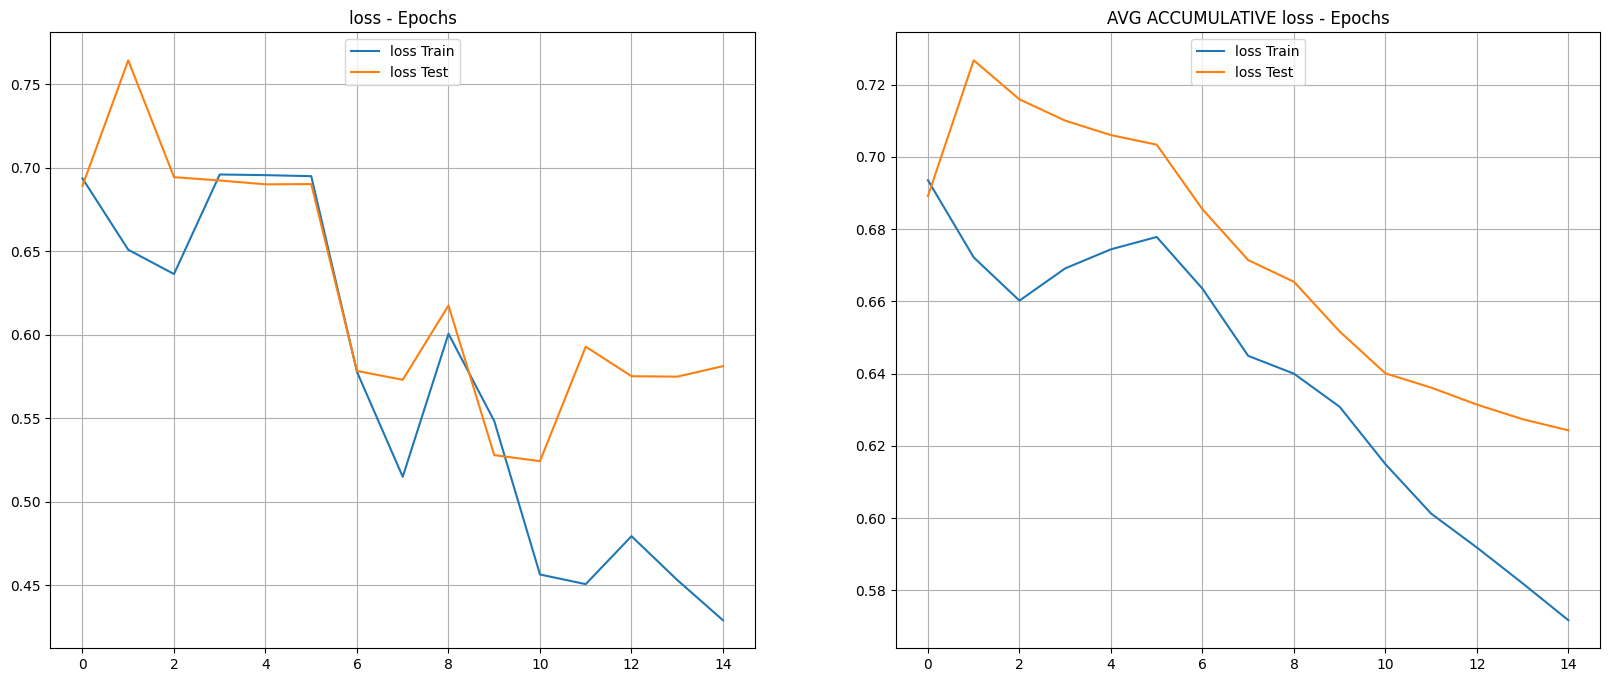

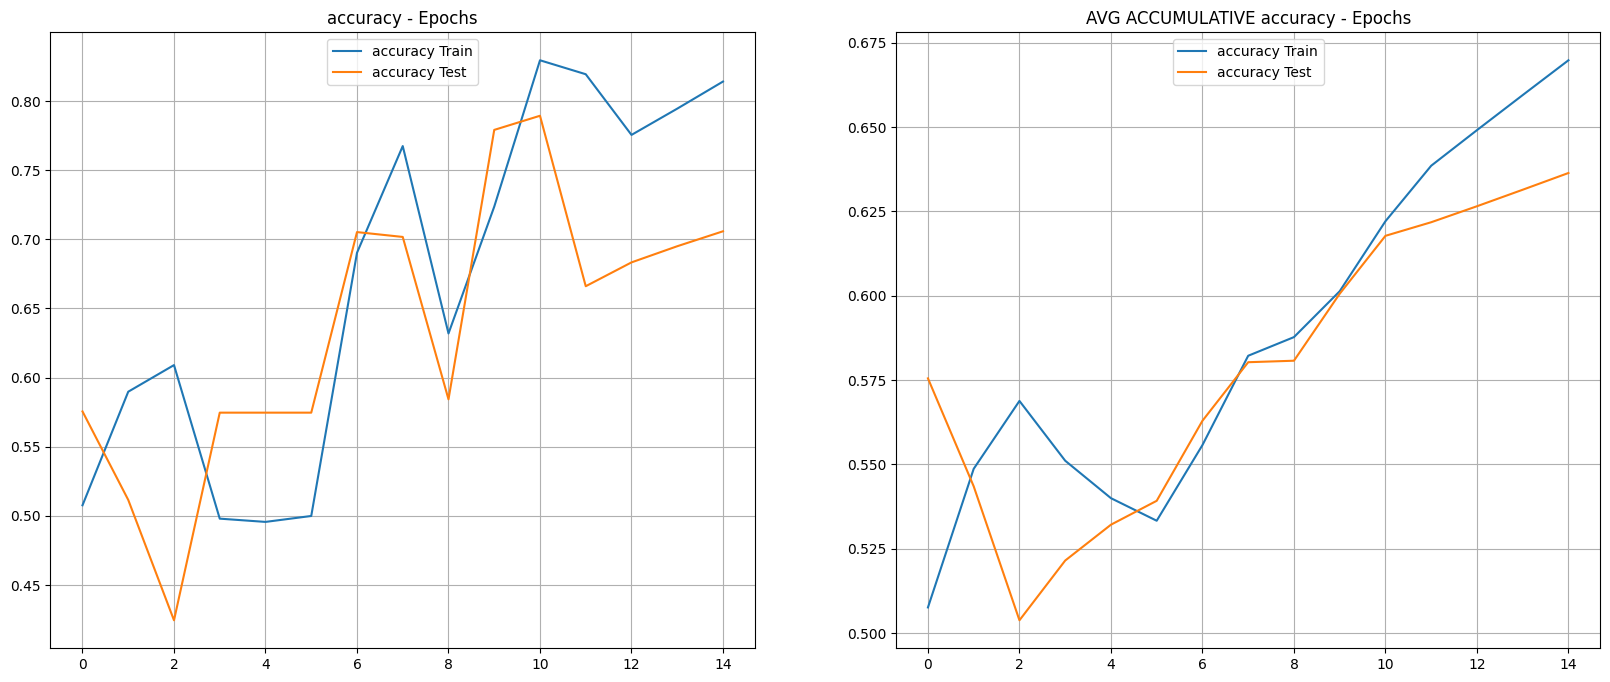

In [14]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

import matplotlib.pyplot as plt

# Pintamos las métricas por epoch
def plot_metric(history, name, remove_first=0):
    metric_train = np.array(history.history[name])[remove_first:]
    metric_test = np.array(history.history['val_{}'.format(name)])[remove_first:]
    acum_avg_metric_train = (np.cumsum(metric_train) / (np.arange(metric_train.shape[-1]) + 1))[remove_first:]
    acum_avg_metric_test = (np.cumsum(metric_test) / (np.arange(metric_test.shape[-1]) + 1))[remove_first:]
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.title('{} - Epochs'.format(name))
    plt.plot(metric_train, label='{} Train'.format(name))
    plt.plot(metric_test, label='{} Test'.format(name))
    plt.grid()
    plt.legend(loc='upper center')
    plt.subplot(1, 2, 2)
    plt.title('AVG ACCUMULATIVE {} - Epochs'.format(name))
    plt.plot(acum_avg_metric_train, label='{} Train'.format(name))
    plt.plot(acum_avg_metric_test, label='{} Test'.format(name))
    plt.grid()
    plt.legend(loc='upper center')
    plt.show()

# Función de perdida
plot_metric(history=history, name='loss')

# Accuracy
plot_metric(history=history, name='accuracy')

#### **Matriz de confusión**

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7058
F1: 0.6991
Precision: 0.7851
Recall: 0.7058
              precision    recall  f1-score   support

           0       0.92      0.53      0.68      1970
           1       0.60      0.94      0.73      1453

    accuracy                           0.71      3423
   macro avg       0.76      0.74      0.70      3423
weighted avg       0.79      0.71      0.70      3423

372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


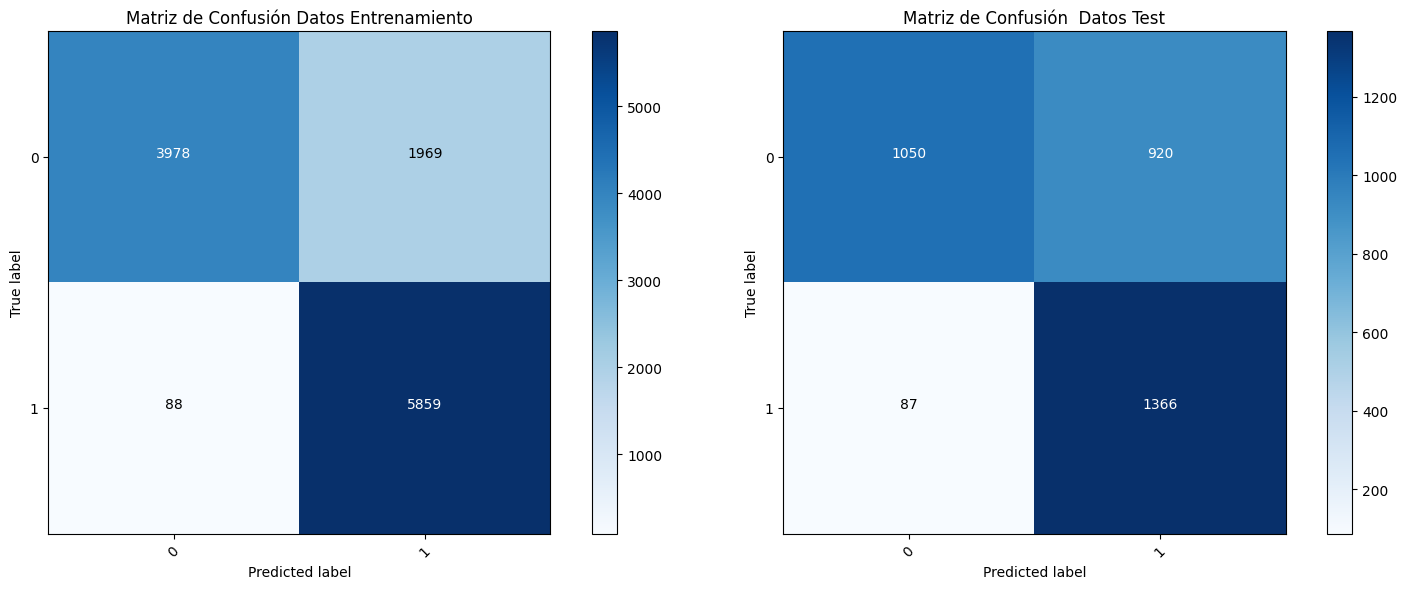

In [15]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

y_true = encoder.inverse_transform(y_test.reshape(-1))
y_pred = np.argmax(model.predict(pad_corpus_test), axis=-1)
y_pred = encoder.inverse_transform(y_pred.reshape(-1))

print('Accuracy: {acc:0.4f}'.format(acc=accuracy_score(y_true=y_true, y_pred=y_pred)))
print('F1: {f1:0.4f}'.format(f1=f1_score(y_true=y_true, y_pred=y_pred, average='weighted')))
print('Precision: {pre:0.4f}'.format(pre=precision_score(y_true=y_true, y_pred=y_pred, average='weighted')))
print('Recall: {rec:0.4f}'.format(rec=recall_score(y_true=y_true, y_pred=y_pred, average='weighted')))
print(classification_report(y_true=y_true, y_pred=y_pred))
labels = [0, 1]
confusion_matrix_test = confusion_matrix(y_true=y_true,
                                         y_pred=y_pred,
                                         labels=labels)
confusion_matrix_train = confusion_matrix(y_true=encoder.inverse_transform(y_train.reshape(-1)), 
                                          y_pred=encoder.inverse_transform(np.argmax(model.predict(pad_corpus_train), axis=-1)), 
                                          labels=labels)

import numpy as np
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Pintamos las matrices de confusión
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_confusion_matrix(confusion_matrix_train, classes=labels, title='Matriz de Confusión Datos Entrenamiento')
plt.subplot(1, 2, 2)
plot_confusion_matrix(confusion_matrix_test, classes=labels, title='Matriz de Confusión  Datos Test')
plt.show()

In [26]:
model.save('model.h5')